In [1]:
!pip install statsmodels==0.12.1

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [3]:
df = pd.read_csv('AMZN.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
1,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
2,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
3,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200
4,1997-05-22,1.437500,1.447917,1.312500,1.395833,1.395833,11776800


# TimeSeries EDA

In [4]:
ts = pd.Series(df.Close.values, index = df.Date)
ts.head()

Date
1997-05-16    1.729167
1997-05-19    1.708333
1997-05-20    1.635417
1997-05-21    1.427083
1997-05-22    1.395833
dtype: float64

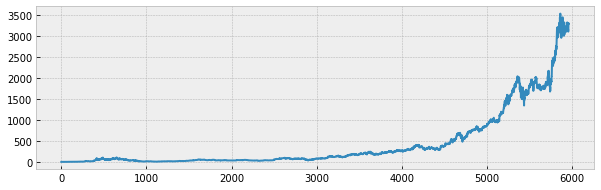

In [5]:
with plt.style.context('bmh'):
  plt.figure(figsize=(10, 3))
  plt.plot(ts.values)

In [6]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')
        y.hist(bins = 20, ax = pp_ax)
        # scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

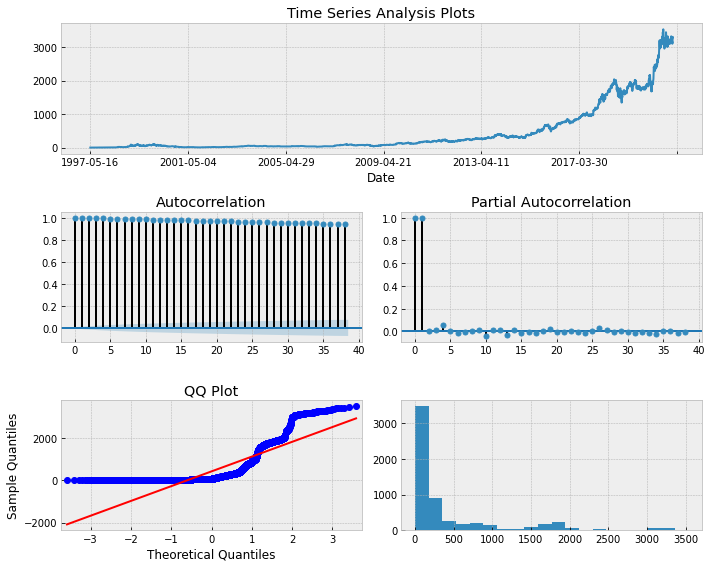

In [7]:
tsplot(ts)

# Bruit blanc ?

In [12]:
?acorr_ljungbox

In [15]:
# Test Bruit Blanc
from statsmodels.stats.diagnostic import acorr_ljungbox
rest_test = acorr_ljungbox(ts.values, lags= 1, return_df= True)
rest_test

,lb_stat,lb_pvalue
1,5943.561693,0.0


pvalue << 0.5 Il ne s'agit pas alors d'un bruit blanc.

# Stationnarité ?

In [16]:
# Test de stationnarité ADF
from statsmodels.tsa.stattools import adfuller
X = ts.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 4.807188
p-value: 1.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

# Décomposition

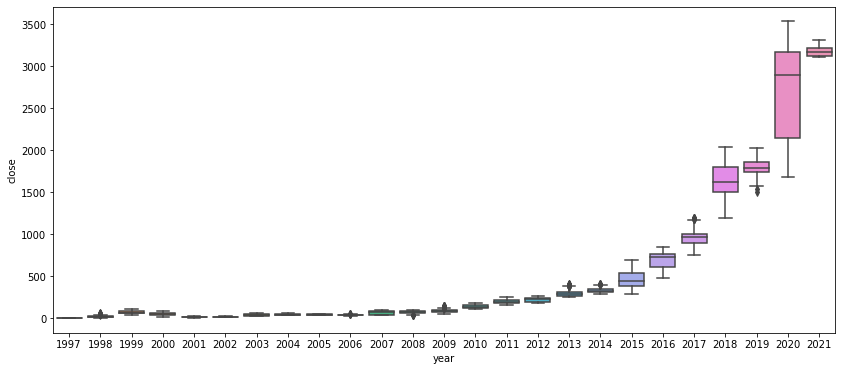

In [157]:
# Tendance annuelle
years = []
for c in list(ts.index):
  years.append(c[:4])

to_plot = pd.DataFrame(list(zip(years, list(ts.values))), columns =['year', 'close']) 
plt.figure(figsize=(14, 6))
sns.boxplot(data = to_plot, x='year', y='close');

Before doing decompostion, how do we select an appropriate value for the frequency parameter? I tested three frequencies for my time series data: 5, 20, and 253. Five because that is how many trading days there are in a week, 20 trading days per month, and 253 per year.

In [22]:
def decompose(ts, model, freq):
  print(f'Decompostion with {model} model and freq = {freq}')
  plt.rcParams['figure.figsize'] = (15, 12)
  res = sm.tsa.seasonal_decompose(ts.values,
                                period=freq,
                                model=model)
  res.plot();

Decompostion with additive model and freq = 253


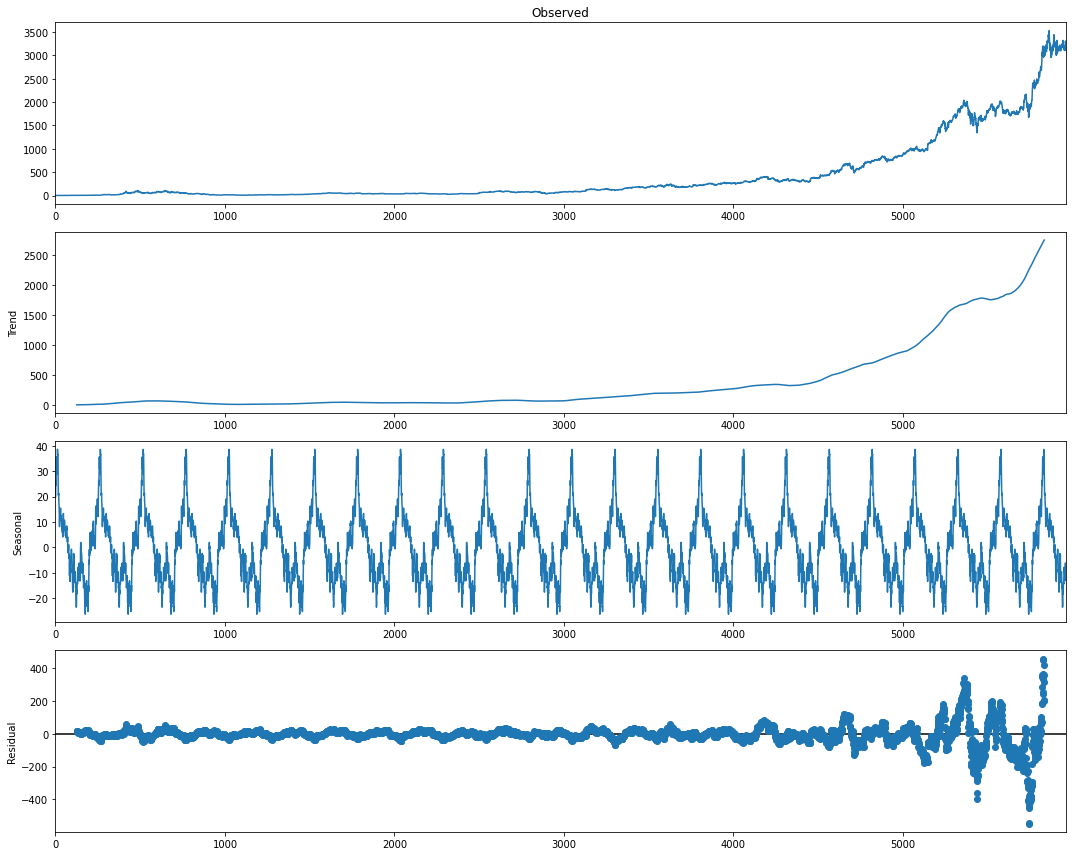

In [23]:
# models with freq = 253
decompose(ts, 'additive', freq=253)

Decompostion with multiplicative model and freq = 253


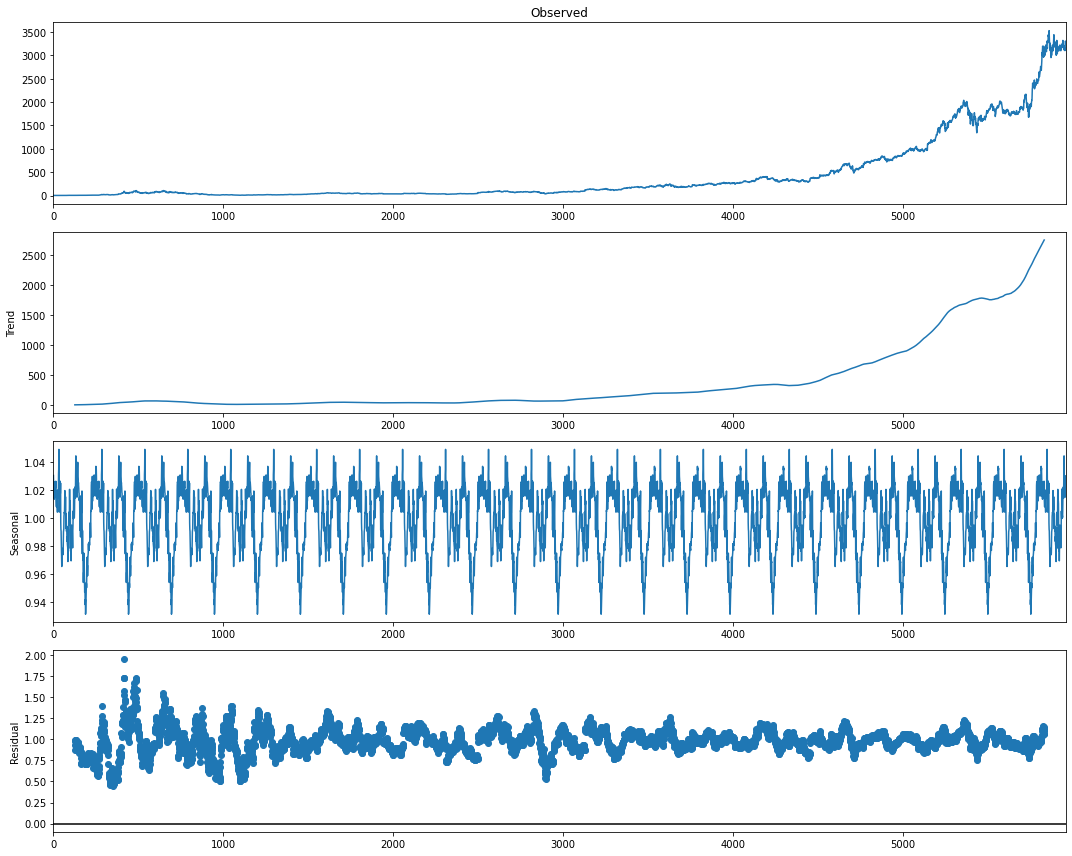

In [24]:
decompose(ts, 'multiplicative', freq=253)

# AR Model

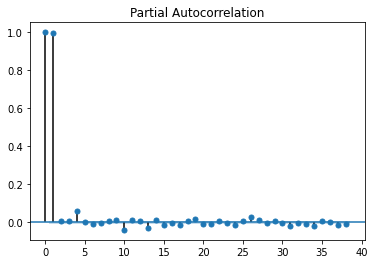

In [25]:
# Visualiser les auto-corrélations partielles
plt.rcParams['figure.figsize'] = (6, 4)
smt.graphics.plot_pacf(ts.values, lags=None, alpha=0.5)
plt.show()

il semble que l'ordre du modèle AR adapté est donc 1, on va vérifier ce constat en traçant y(t+1) en fonction de y(t).

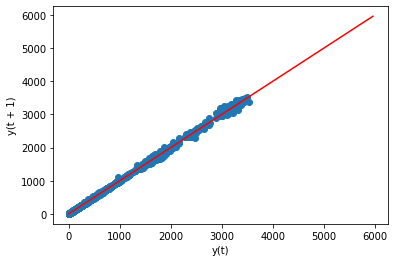

In [36]:
# Visualiser y(t+1) en fonction de y(t)
pd.plotting.lag_plot(ts, lag = 1)
plt.plot(range(len(ts)),range(len(ts)),'red');

L'ordre p est donc 1

In [38]:
# calculer les coefficients d'autocorrelation
def autocorr(ts, lag=10):
  y = ts.values
  y = y - np.mean(y)
  c = np.correlate(y, y, 'full')
  mid = len(c)//2
  acov = c[mid:mid+lag]
  acor = acov/acov[0]
  return(acor)

In [39]:
autocorr(ts, lag=10)

array([1.        , 0.99828501, 0.99658862, 0.99492433, 0.99345105,
       0.99198394, 0.9904853 , 0.98896409, 0.98746152, 0.98600794])

In [40]:
# trouver coefficients AR(p) avec Yule Walker
from scipy import signal, linalg
def fit(ts, p=1):
    ac = autocorr(ts, p+1)
    R = linalg.toeplitz(ac[:p])
    r = ac[1:p+1]
    phi = linalg.inv(R).dot(r)
    return phi

In [41]:
# Le coefficient du Modèle AR(1)
fit(ts, p=1)

array([0.99828501])

In [42]:
# Traçer un processus AR(1) avec le coefficient estimé
def plotProcessAR1(ts, rho=0):
  y = ts.values
  n_samples = len(y)
  x = w = np.random.normal(size=n_samples)
  for t in range(n_samples):
    x[t] = rho * x[t-1] + w[t]
  with plt.style.context('bmh'):
    plt.figure(figsize=(10, 3))
    plt.plot(x)
    plt.plot(y)
    plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))

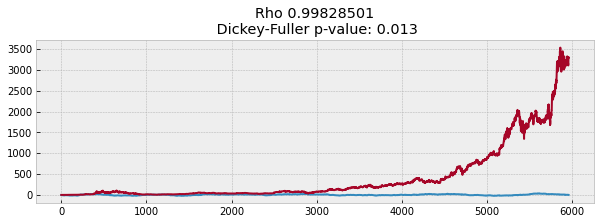

In [43]:
plotProcessAR1(ts, rho=0.99828501)

Le process AR(1) ne modélise pas parfaitement la totalité de la série, mais il se peut qu'il a réussi à capter au moins le comportement de la première partie càd les 3000 premiers jours.

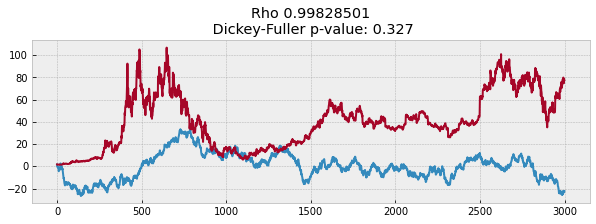

In [44]:
plotProcessAR1(ts.iloc[:3000], rho=0.99828501)

Essayons maintenant d'aller à un ordre de 2

In [47]:
# Le coefficient du Modèle AR(2) avec walker
print('Les coefficients de AR(p=2) :')
print(fit(ts, p=2))

# Simuler un processus AR(2)
def plotProcessAR2(ts, rho1=0, rho2=0):
  y = ts.values
  n_samples = len(y)
  x = w = np.random.normal(size=n_samples)
  for t in range(1, n_samples):
    x[t] = rho1 * x[t-1]+ rho2 * x[t-2] + w[t]
  with plt.style.context('bmh'):
    plt.figure(figsize=(10, 3))
    plt.plot(x)
    plt.plot(y)
    plt.title("Rho1 {}\nRho2 {}\n Dickey-Fuller p-value: {}".format(rho1,rho2, round(sm.tsa.stattools.adfuller(x)[1], 3)))

Les coefficients de AR(p=2) :
[0.99372694 0.00456591]


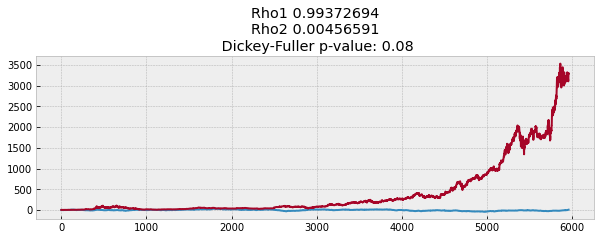

In [48]:
plotProcessAR2(ts, rho1=0.99372694, rho2=0.00456591)

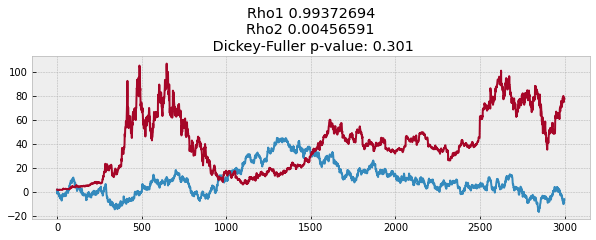

In [50]:
plotProcessAR2(ts.iloc[:3000], rho1=0.99372694, rho2=0.00456591)

Essayons de différencier la série pour la rendre stationnaire et facile à modéliser.

In [51]:
from pandas import Series as Series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

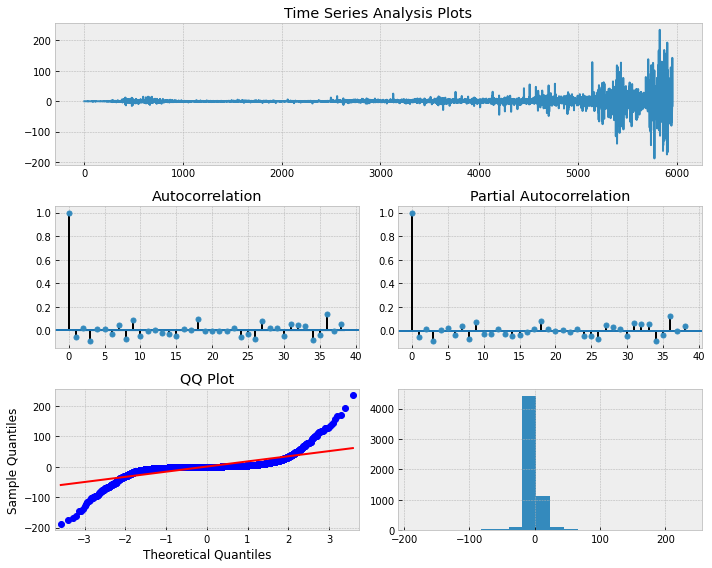

In [52]:
# Visualiser la série différenciée
tsplot(difference(ts.values))

La série différenciée semble être un bruit blanc, on ne constate pas la présence de pics au niveau des diagrammes des auto-corrélations. On gardera alors la série d'origine, et on effectue une grid-search pour trouver l'ordre optimal du modèle AR.

In [59]:
from sklearn.metrics import mean_squared_error as mse
from statsmodels.tsa.ar_model import AutoReg
score_bic = []
score_aic = []
score_mse = []
c=[]
for i in range(1,20):
    c.append(i)
    mdl = AutoReg(ts.values, lags= c, trend='ct', old_names=False)
    res = mdl.fit()
    score_bic.append(res.bic)
    score_aic.append(res.aic)
    n_fitted = len(res.fittedvalues)
    score_mse.append(mse( res.fittedvalues, ts.values[:n_fitted]  ))  

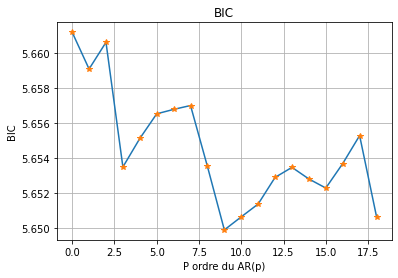

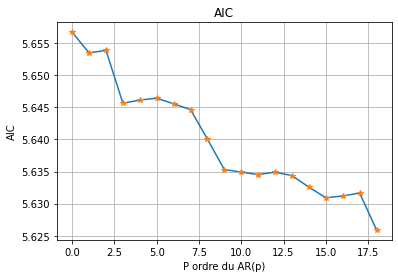

In [60]:
fig, ax = plt.subplots(0,0)
plt.title("BIC")
plt.xlabel("P ordre du AR(p)")
plt.ylabel("BIC")
plt.plot(score_bic)
plt.plot(score_bic, '*')
plt.grid()

fig, ax = plt.subplots(0,1)
plt.title("AIC")
plt.xlabel("P ordre du AR(p)")
plt.ylabel("AIC")
plt.plot(score_aic)
plt.plot(score_aic, '*')
plt.grid()

Nous choisissons alors un ordre de 9 pour modéliser la série par un modèle AR vu qu'il donne le BIC optimal.

In [61]:
# AR(9)
ord = list(range(1,10))
mdl = AutoReg(ts.values, lags= ord, trend='ct', old_names=False)
res = mdl.fit()

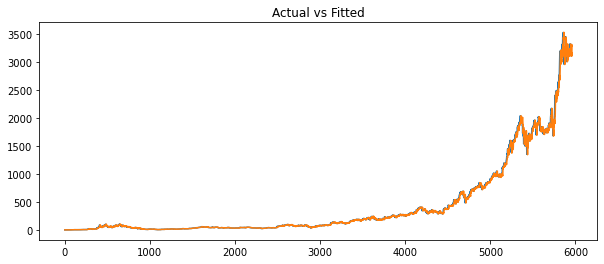

In [62]:
fig = plt.figure(figsize=(10,4))
plt.plot(res.fittedvalues)
plt.plot(ts.values)
plt.title('Actual vs Fitted');

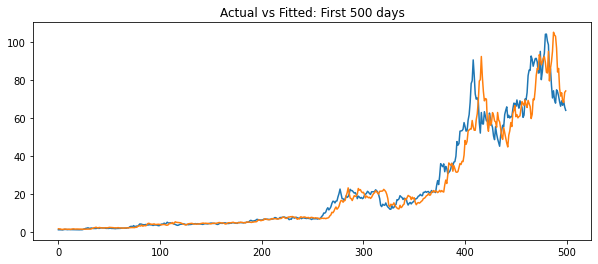

In [66]:
fig = plt.figure(figsize=(10,4))
plt.plot(res.fittedvalues[:500])
plt.plot(ts.values[:500])
plt.title('Actual vs Fitted: First 500 days');

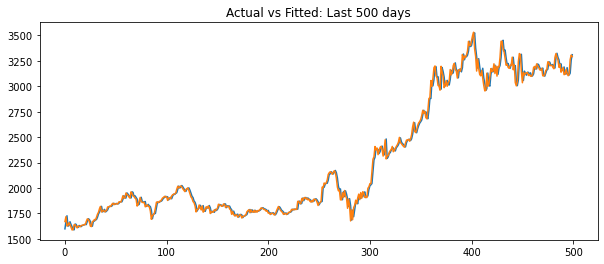

In [65]:
fig = plt.figure(figsize=(10,4))
plt.plot(res.fittedvalues[-500:])
plt.plot(ts.values[-500:])
plt.title('Actual vs Fitted: Last 500 days');

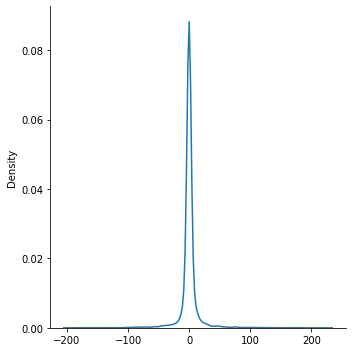

In [75]:
# Distribution des résidus
sns.displot(res.resid,kind="kde");

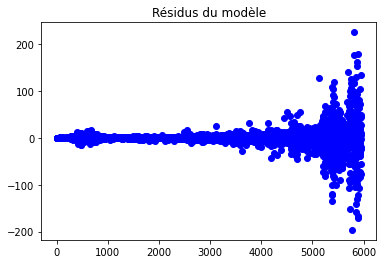

In [85]:
plt.plot(res.resid,'bo')
plt.title('Résidus du modèle')
plt.show()

Les résidus sont centrés avec une variance constante au niveau des premiers 3000 jours. Ainsi on peut valider l'utilisation du AR pour modèliser cette partie.

# ARMA Model
Essayons maintenant d'introduire une composante MA pour construire un modèle ARMA.

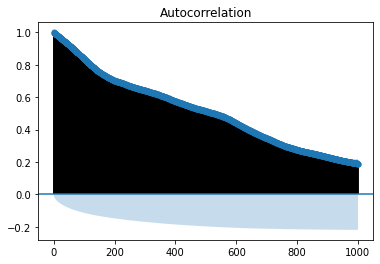

In [ ]:
# Visualiser les auto-corrélations partielles
smt.graphics.plot_acf(ts.values, lags=1000, alpha=0.5)
plt.show()

In [90]:
#fit ARMA(9,5) model to dataset
from statsmodels.tsa.arima.model import ARIMA
# fit model
best_model = ARIMA(ts.values, order=(9,0,5), trend= 'ct', enforce_stationarity= True)
model_fit = best_model.fit()
# summary of fit model
print(model_fit.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5961
Model:                 ARIMA(9, 0, 5)   Log Likelihood              -25200.961
Date:                Thu, 28 Jan 2021   AIC                          50435.922
Time:                        21:24:50   BIC                          50549.703
Sample:                             0   HQIC                         50475.448
                               - 5961                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -475.7017   1.59e-06  -2.99e+08      0.000    -475.702    -475.702
x1             1.0738      0.236      4.544      0.000       0.611       1.537
ar.L1         -0.8946      0.008   -109.185      0.0

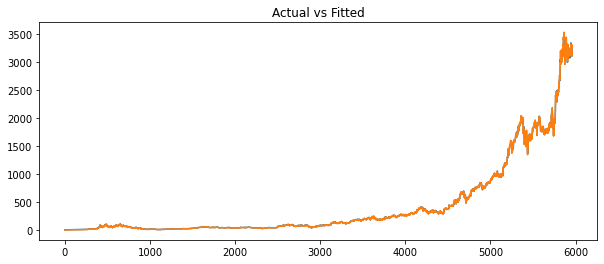

In [91]:
fig = plt.figure(figsize=(10,4))
plt.plot(model_fit.fittedvalues[1:])
plt.plot(ts.values[1:])
plt.title('Actual vs Fitted');

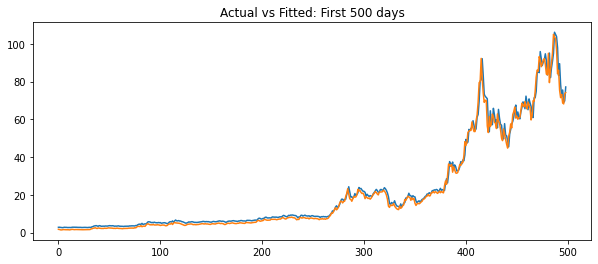

In [92]:
fig = plt.figure(figsize=(10,4))
plt.plot(model_fit.fittedvalues[1:500])
plt.plot(ts.values[1:500])
plt.title('Actual vs Fitted: First 500 days');

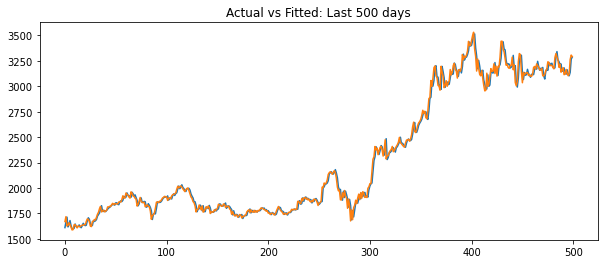

In [93]:
fig = plt.figure(figsize=(10,4))
plt.plot(model_fit.fittedvalues[-500:])
plt.plot(ts.values[-500:])
plt.title('Actual vs Fitted: Last 500 days');

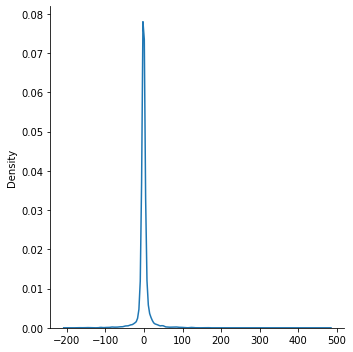

In [94]:
# Distribution des résidus
sns.displot(model_fit.resid,kind="kde");

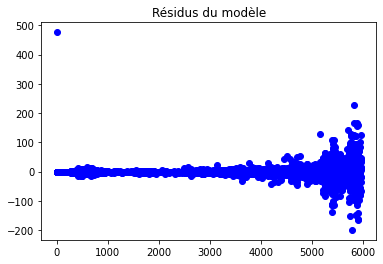

In [95]:
plt.plot(model_fit.resid,'bo')
plt.title('Résidus du modèle')
plt.show()

In [106]:
rmse = mse(model_fit.fittedvalues, ts.values, squared= False)
print(f'RMSE DU MODELE = {round(rmse,2)}')

RMSE DU MODELE = 17.68


# ARIMA Model
Essayons maintenant de différencier la série pour voir l'impact sur la modèlisation.

In [107]:
#fit ARIMA(9,1,5) model to dataset
from statsmodels.tsa.arima.model import ARIMA
# fit model
best_model = ARIMA(ts.values, order=(9,1,5), trend= 'ct', enforce_stationarity= True)
model_fit = best_model.fit()
# summary of fit model
print(model_fit.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5961
Model:                 ARIMA(9, 1, 5)   Log Likelihood              -25256.564
Date:                Thu, 28 Jan 2021   AIC                          50547.128
Time:                        21:34:46   BIC                          50660.906
Sample:                             0   HQIC                         50586.653
                               - 5961                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.082e-09   8.52e-08      0.024      0.980   -1.65e-07    1.69e-07
x1             0.5503      0.198      2.782      0.005       0.163       0.938
ar.L1         -0.8585      0.087     -9.845      0.0

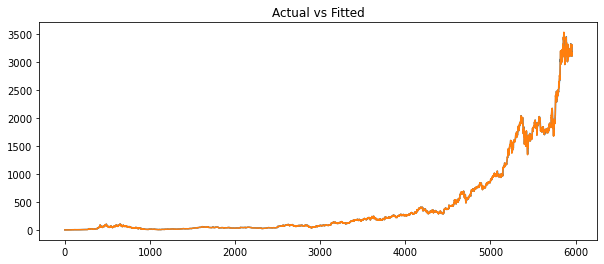

In [108]:
fig = plt.figure(figsize=(10,4))
plt.plot(model_fit.fittedvalues[1:])
plt.plot(ts.values[1:])
plt.title('Actual vs Fitted');

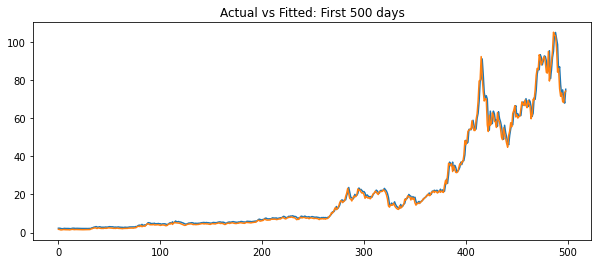

In [109]:
fig = plt.figure(figsize=(10,4))
plt.plot(model_fit.fittedvalues[1:500])
plt.plot(ts.values[1:500])
plt.title('Actual vs Fitted: First 500 days');

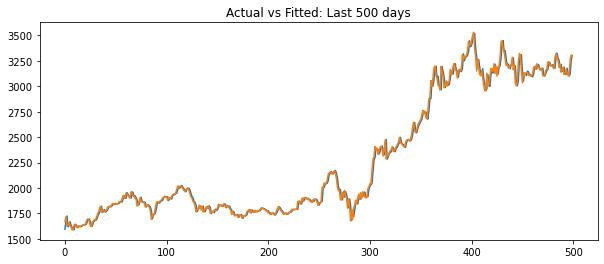

In [110]:
fig = plt.figure(figsize=(10,4))
plt.plot(model_fit.fittedvalues[-500:])
plt.plot(ts.values[-500:])
plt.title('Actual vs Fitted: Last 500 days');

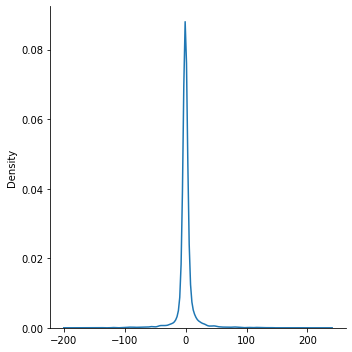

In [111]:
# Distribution des résidus
sns.displot(model_fit.resid,kind="kde");

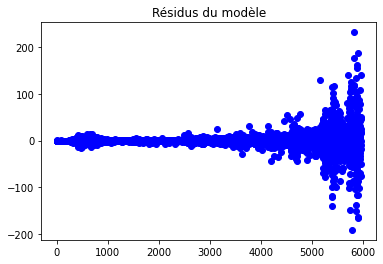

In [112]:
plt.plot(model_fit.resid,'bo')
plt.title('Résidus du modèle')
plt.show()

In [113]:
rmse = mse(model_fit.fittedvalues, ts.values, squared= False)
print(f'RMSE DU MODELE = {round(rmse,2)}')

RMSE DU MODELE = 16.75


La différenciation a amélioré alors le modèle

# Prophet

In [143]:
from fbprophet import Prophet
dfr = df[['Date','Close']]
dfr.columns=['ds','y']
#instantiate Prophet with only yearly seasonality
model = Prophet( yearly_seasonality=True) 
model.fit(dfr)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


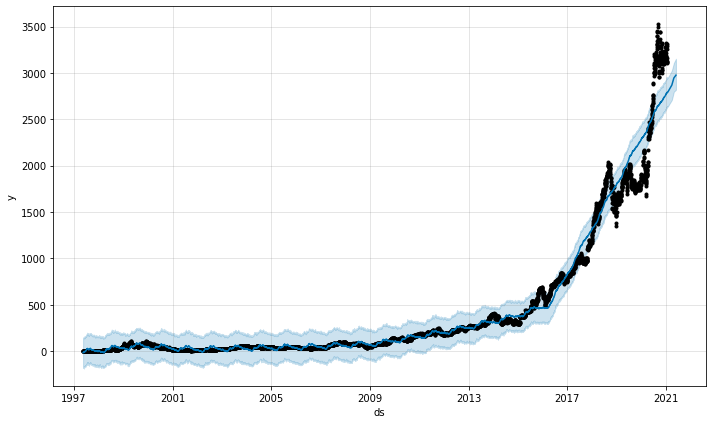

In [148]:
model.plot(forecast)
plt.show()

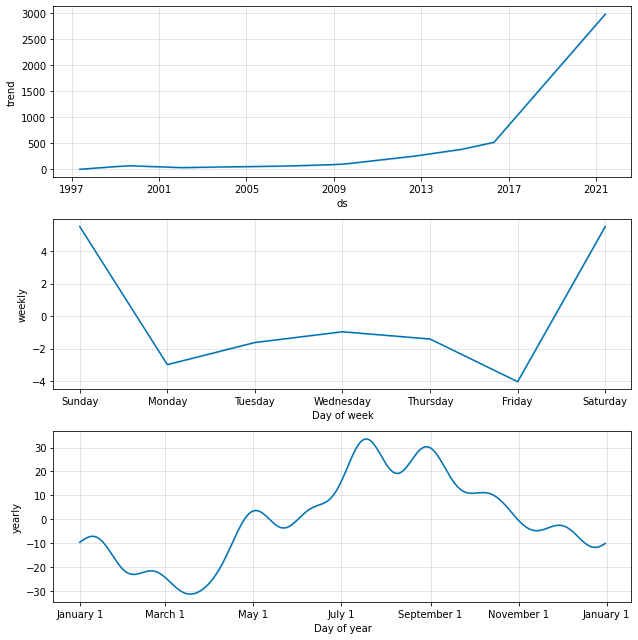

In [147]:
model.plot_components(forecast)
plt.show()

The trend and yearly seasonality from Prophet look similar to the ones that we had earlier using the traditional methods.